In [1]:
import os
import io
import numpy as np
import pymupdf  # PyMuPDF
from PIL import Image

from decimer_segmentation import (
    segment_chemical_structures,
    segment_chemical_structures_from_file,
)

/home/kohulan/anaconda3/envs/DECIMER_IMGSEG/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
2025-07-17 10:54:45.271773: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 10:54:45.321293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-17 10:54:45.321334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-17 10:54:45.323030: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been 

## Define pdf path and convert to image

Please uncomment according to the system you are using. 
If you are using Windows, make sure, poppler is installed properly.
On Linux and MacOS, this should work properly without any problems. 

#### Uncomment below according to your needs. 

In [3]:
import os
from pathlib import Path
import pymupdf  # PyMuPDF


def pdf_extract(pdf, segments, together=False):
    """
    Extract pages from a PDF using PyMuPDF

    Args:
        pdf: str | Path - path to the input PDF file
        segments: list of tuples or dicts - [(start, end), {'start': int, 'end': int}]
        together: bool - if True, combine all segments into one output file
    """
    pdf_path = Path(pdf)

    # Open the source PDF
    src_doc = pymupdf.open(pdf)

    if together:
        # Create a single output document for all segments
        output_doc = pymupdf.open()

        for segment in segments:
            # Support both dict format {'start': 3, 'end': 3} and tuple format (start, end)
            try:
                start_page, end_page = segment["start"], segment["end"]
            except (TypeError, KeyError):
                start_page, end_page = segment

            # Convert to 0-based indexing and copy pages
            for page_num in range(start_page - 1, end_page):
                if page_num < src_doc.page_count:  # Check if page exists
                    output_doc.insert_pdf(src_doc, from_page=page_num, to_page=page_num)

        # Save the combined document
        output_path = pdf_path.parent / f"{pdf_path.stem}_extracted.pdf"
        output_doc.save(output_path)
        output_doc.close()
        print(f"Combined extraction saved to: {output_path}")

    else:
        # Create separate output files for each segment
        for segment in segments:
            # Support both dict format {'start': 3, 'end': 3} and tuple format (start, end)
            try:
                start_page, end_page = segment["start"], segment["end"]
            except (TypeError, KeyError):
                start_page, end_page = segment

            # Create a new document for this segment
            segment_doc = pymupdf.open()

            # Copy pages for this segment
            for page_num in range(start_page - 1, end_page):
                if page_num < src_doc.page_count:  # Check if page exists
                    segment_doc.insert_pdf(
                        src_doc, from_page=page_num, to_page=page_num
                    )

            # Save this segment
            output_path = (
                pdf_path.parent / f"{pdf_path.stem}_pages_{start_page}-{end_page}.pdf"
            )
            segment_doc.save(output_path)
            segment_doc.close()
            print(f"Segment {start_page}-{end_page} saved to: {output_path}")

    # Close the source document
    src_doc.close()


# path: str = os.path.abspath("./Validation/TW215080B.pdf")
path: str = os.path.abspath("./Validation/KR102075885B1.pdf")
pdf_extract(path, [(10, 20)])

Segment 10-20 saved to: /home/kohulan/DECIMER-Image-Segmentation/Validation/KR102075885B1_pages_10-20.pdf


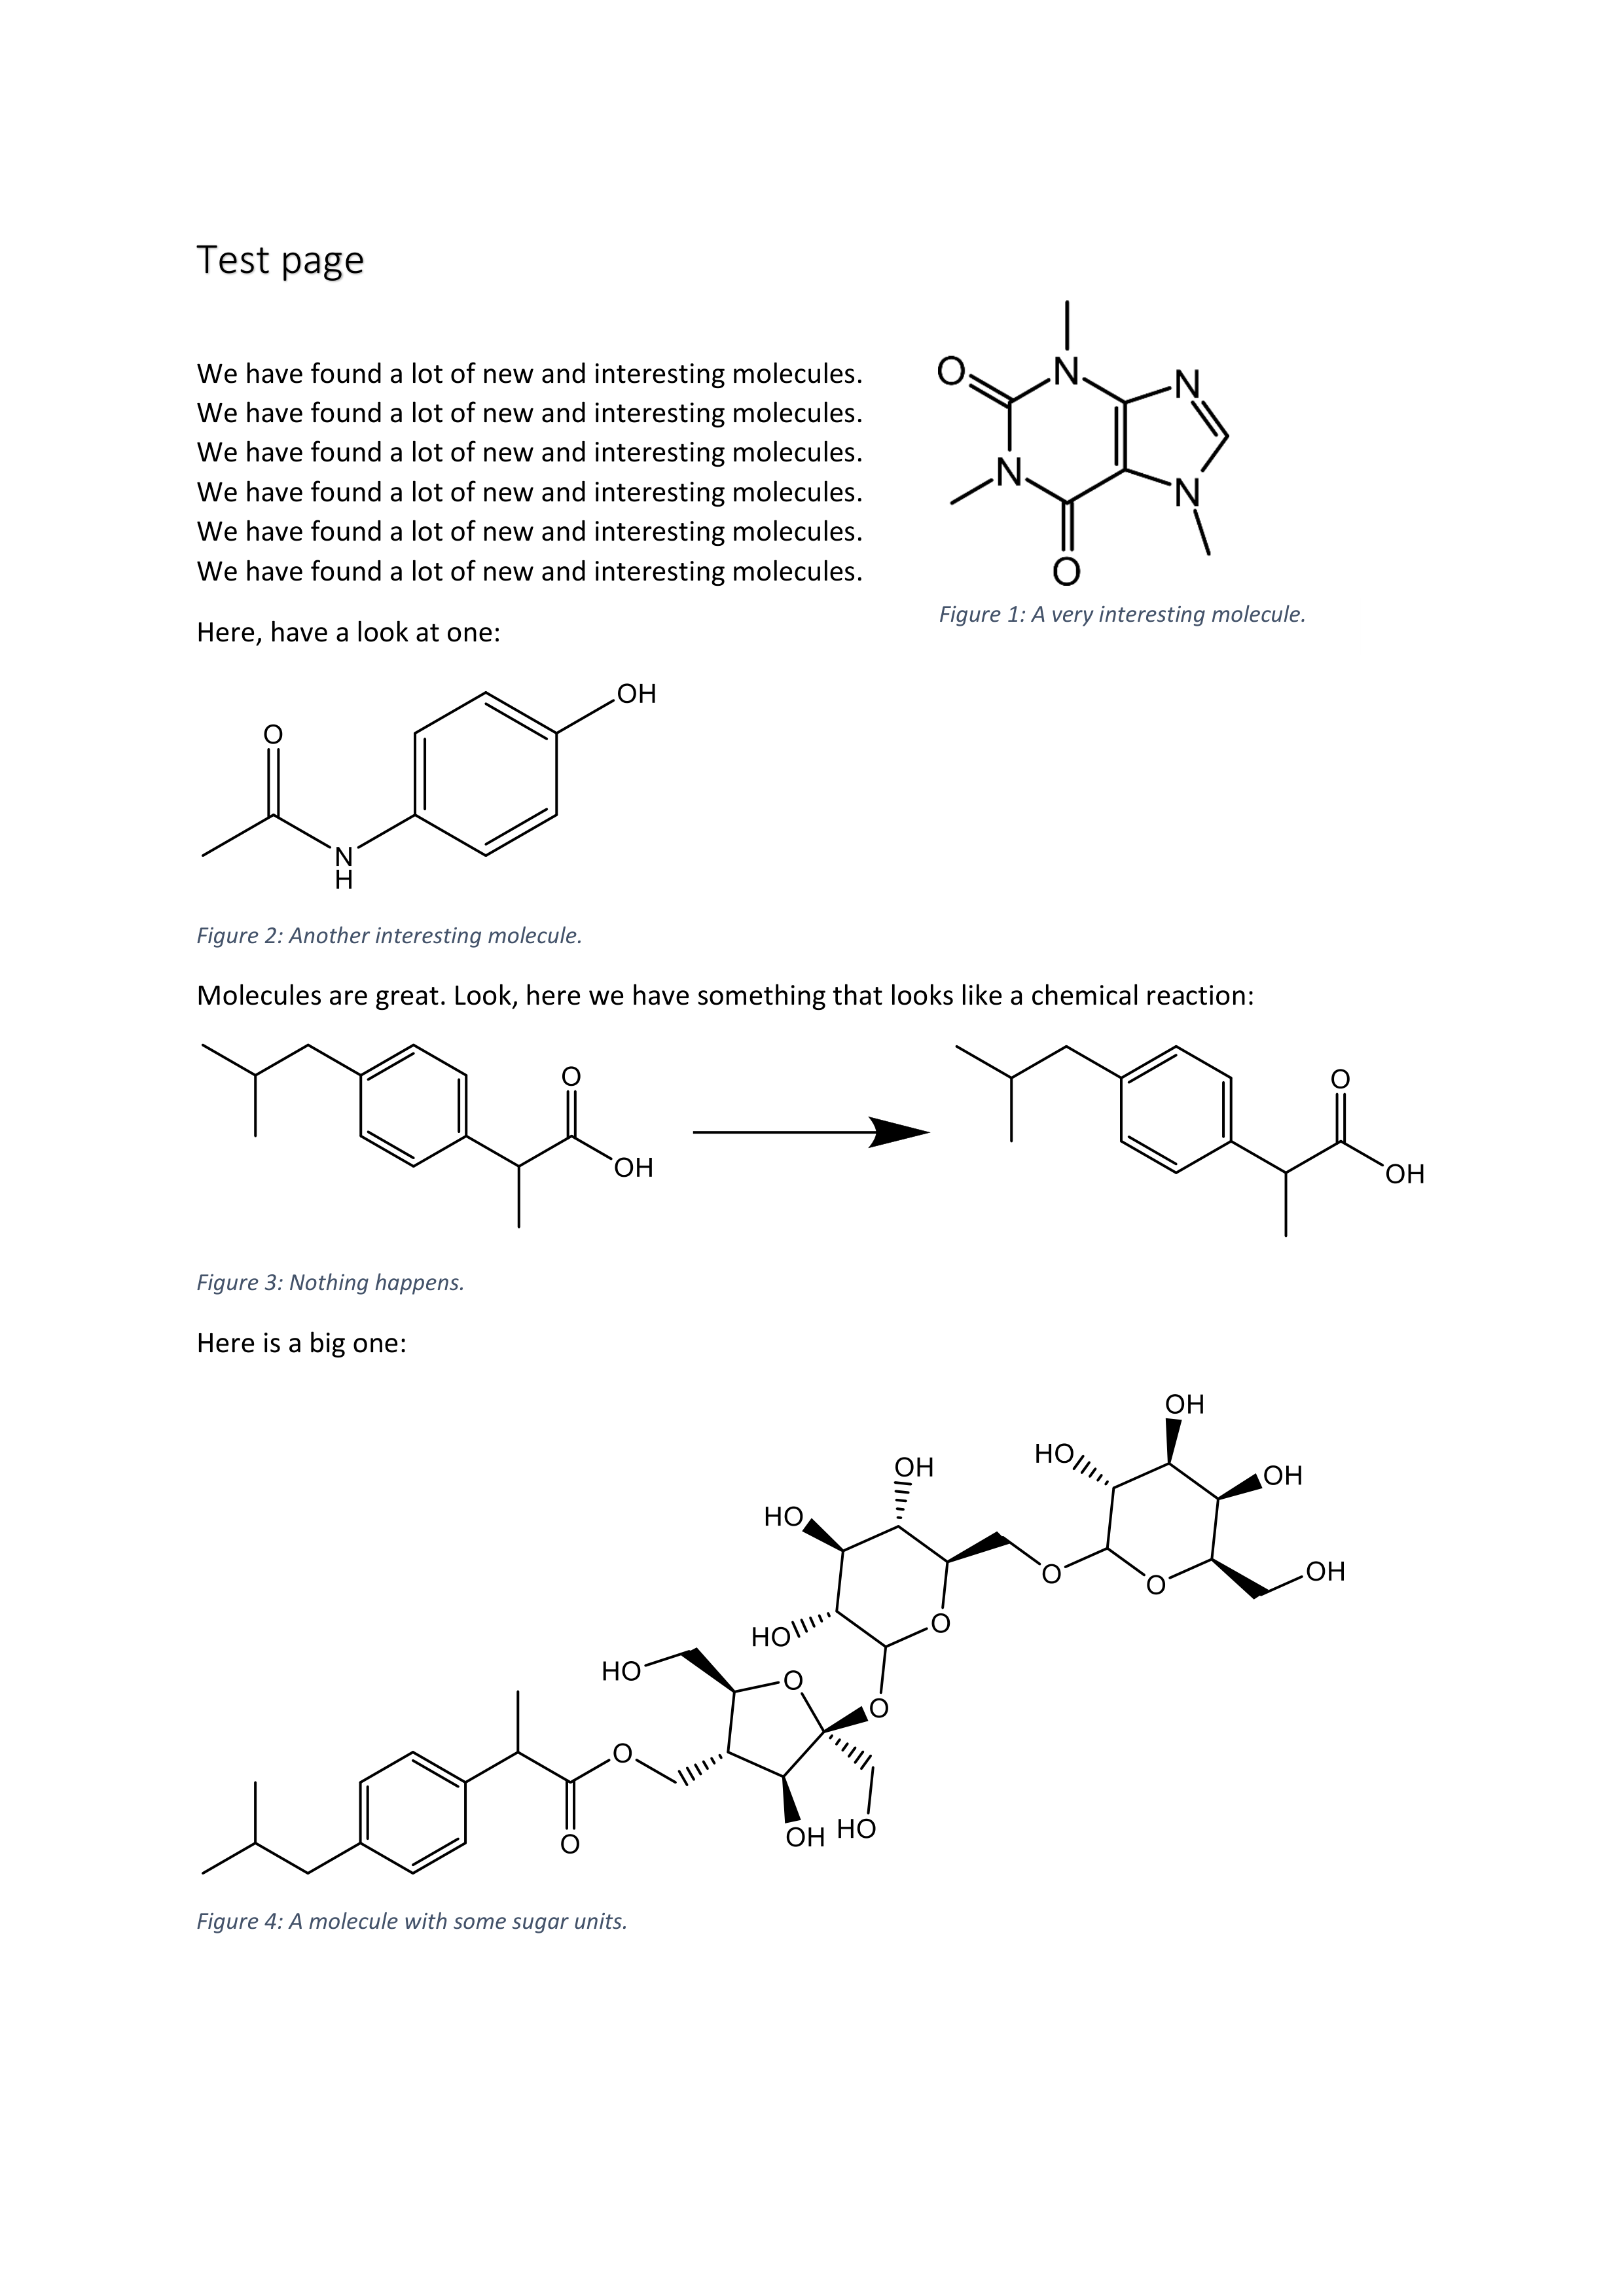

In [4]:
path: str = os.path.abspath("./Validation/test_page.pdf")
# path: str = os.path.abspath("./Validation/page 35.pdf")
# path: str = os.path.abspath("./Validation/TW215080B_pages_45-55.pdf")
# path: str = os.path.abspath("./Validation/KR102075885B1_pages_10-20.pdf")

# Convert PDF to images using PyMuPDF (no poppler installation needed!)
pdf_document = pymupdf.open(path)
pages = []
for page_num in range(pdf_document.page_count):
    page = pdf_document[page_num]
    # Render page to image with 300 DPI
    pix = page.get_pixmap(matrix=pymupdf.Matrix(300 / 72, 300 / 72))
    img_data = pix.tobytes("ppm")
    # Convert to PIL Image
    img = Image.open(io.BytesIO(img_data))
    pages.append(img)
pdf_document.close()

# Display the page
pages[0] if pages else "No pages found"

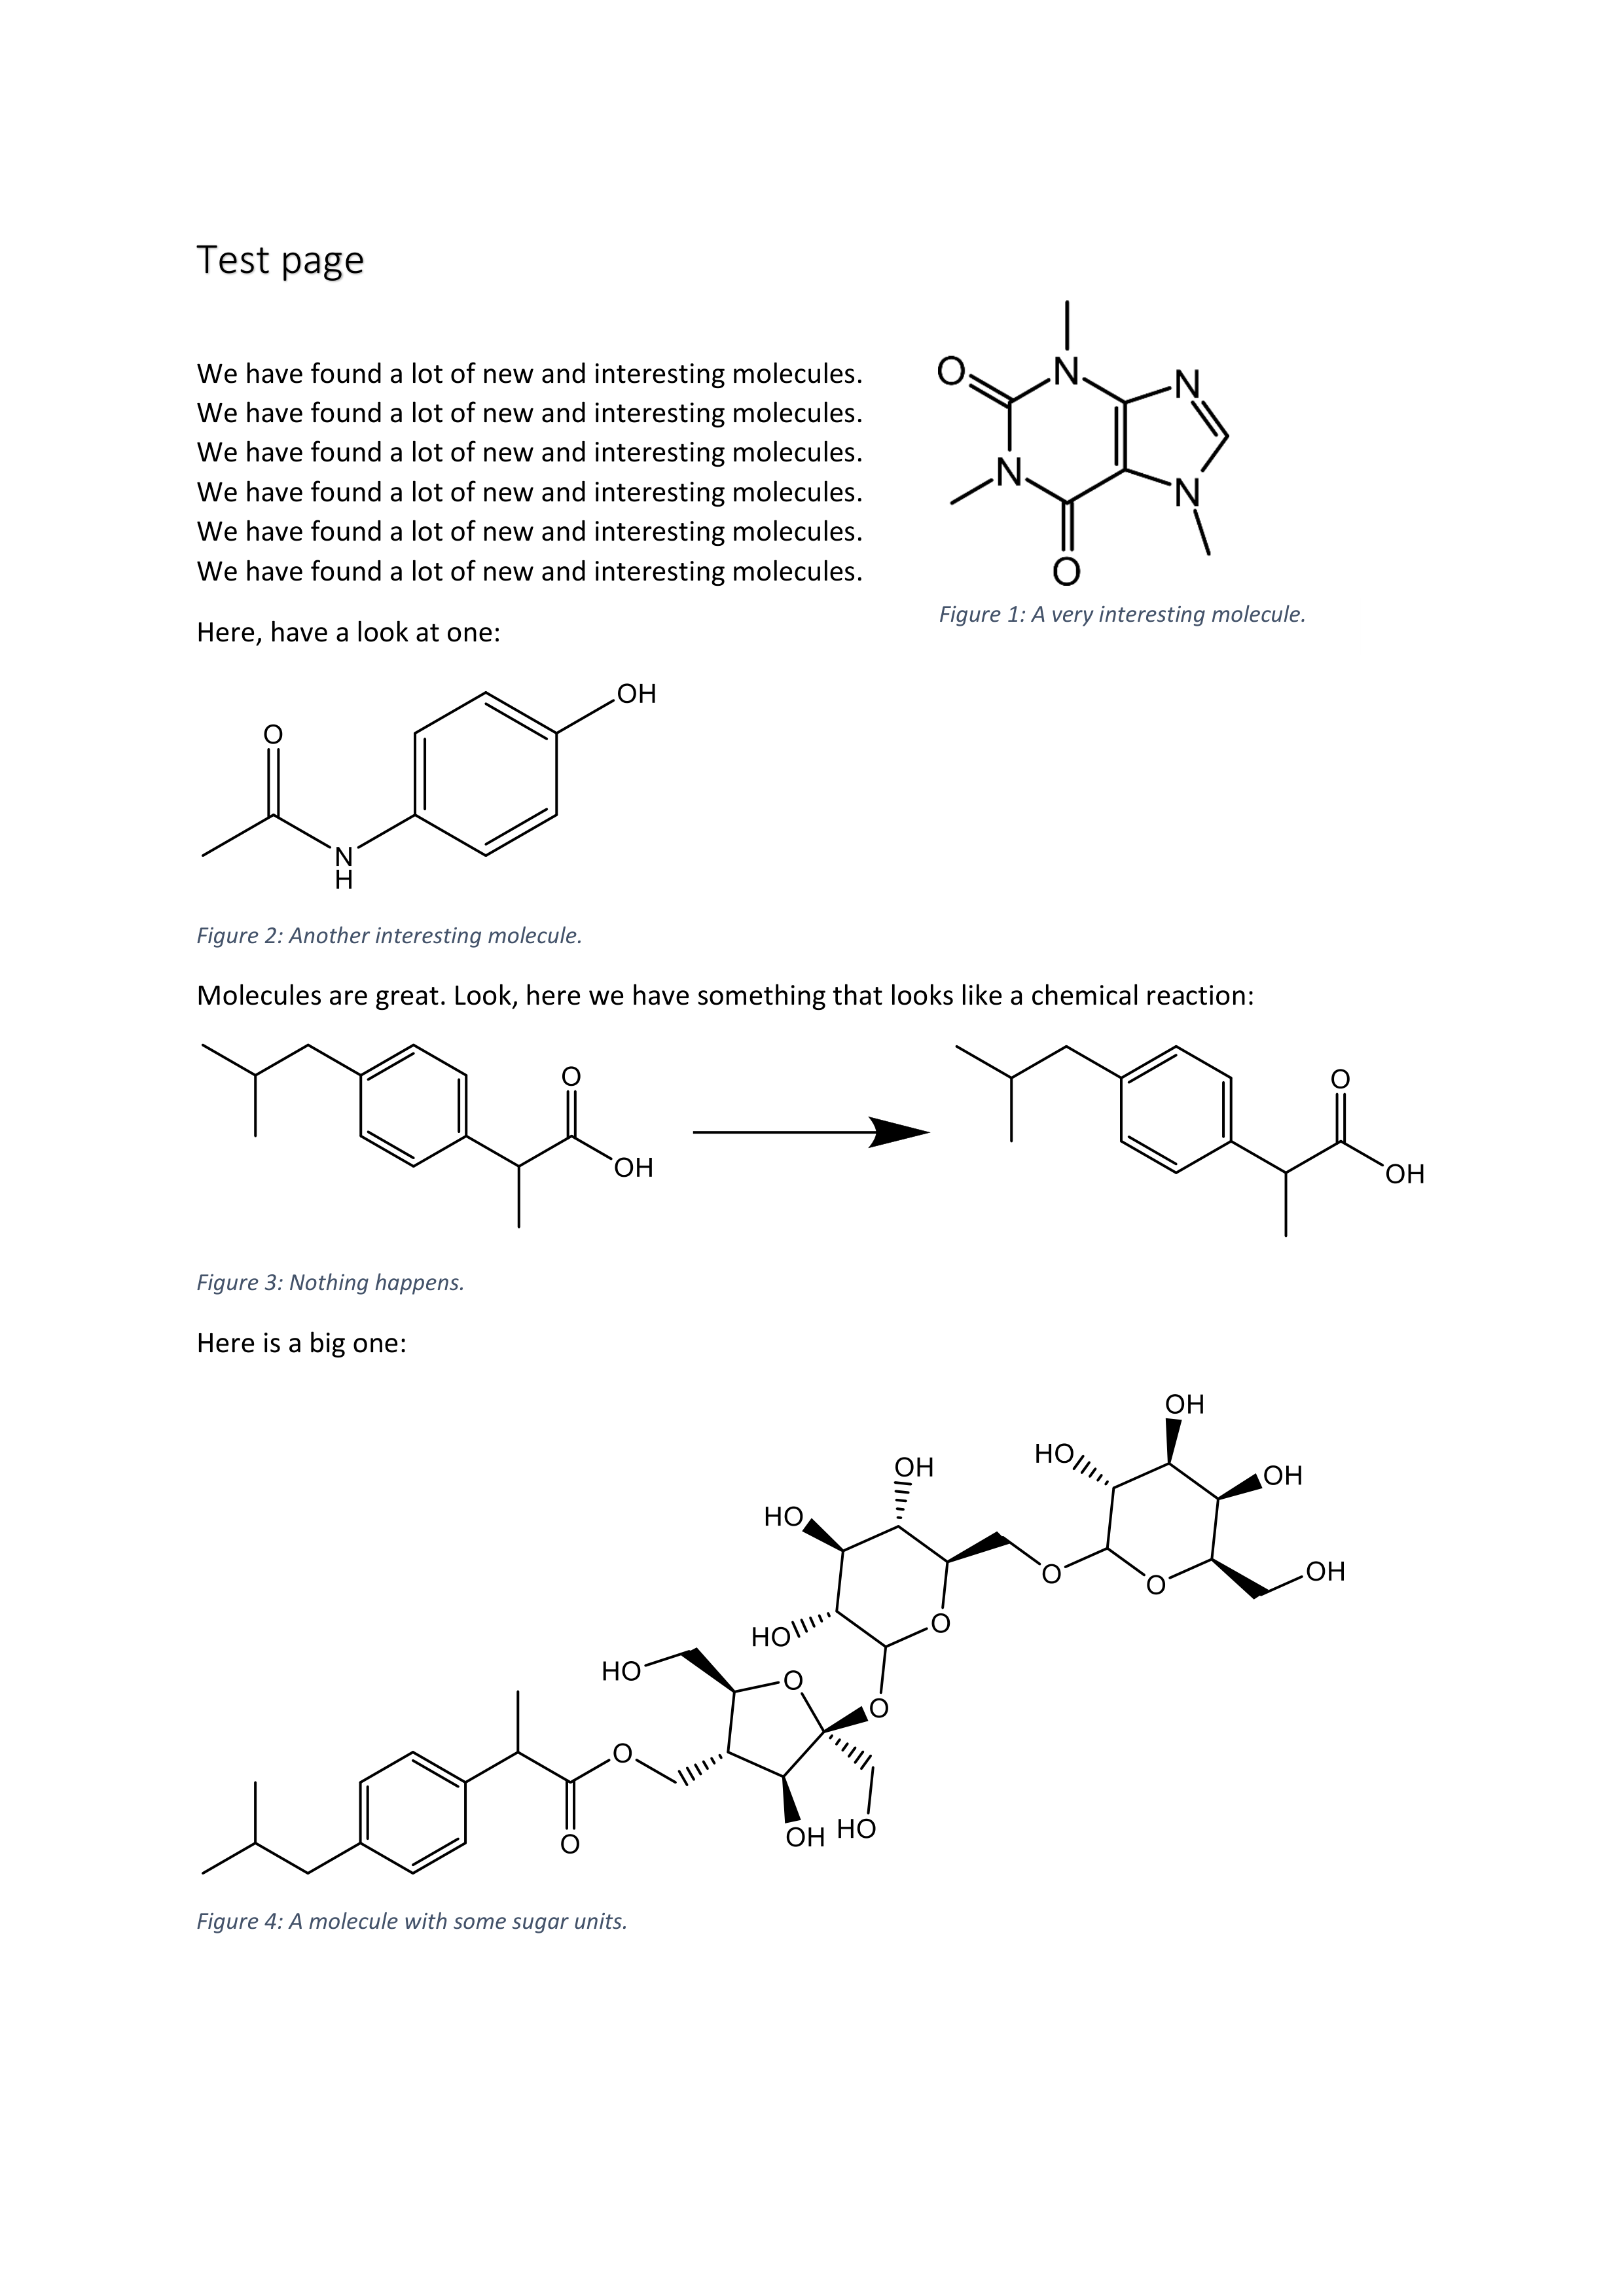

In [5]:
pages[0] if len(pages) > 0 else "No pages available"

## Run the detection using the Mask R CNN model

In [ ]:
segments = segment_chemical_structures(
    np.array(pages[0]), expand=False, visualization=True
)

## Run DECIMER Segmentation with the mask expansion


In [ ]:
segments = segment_chemical_structures(
    np.array(pages[0]), expand=True, visualization=True
)

## Run DECIMER Segmentation directly on a file

With PyMuPDF, no poppler installation is required! The poppler_path argument is now deprecated and will be ignored.

In [ ]:
path = os.path.abspath("./Validation/test_page.pdf")
# poppler_path is now deprecated with PyMuPDF - no longer needed!
segments = segment_chemical_structures_from_file(path, expand=True)
# Show first segment
Image.fromarray(segments[0]) if segments else "No segments found"